# SUPER COMPUTAÇÃO
Fernando Fincatti, 7º semestre

### INTRODUÇÃO

O presente trabalho tem como objetivo a análise de todas as 6 implementações desenvolvidas ao longo do curso de super computação, sendo elas: solução heurística, busca local, busca exaustiva, busca exaustiva paralelizada em CPU e busca exaustiva paralelizada em CPU + GPU.

Todos os algoritmos tem como função resolver o problema de alinhamento de sequências de DNA, o qual consiste no processo de comparar duas ou mais sequências de bases de forma a se observar seu nível de similaridade, que por sua vez pode ser calculado com base em um sistema de pontuação, no qual acertos (MATCH) resultam em pontos positivos, ao passo que os erros (MISS MATCH ou GAPS) resultam em pontos negativos. 

O sistema de pontuação utilizado é apresentado abaixo:

*   MATCH = 2
*   MISS MATCH = -1
*   GAP = -1

Dessa forma, cada uma das 6 abordagens tem como objetivo encontrar o máximo nível de similaridade, o score, entre as duas sequências de entrada.




#### SOLUÇÃO HEURÍSTICA

A abordagem da solução heurística consiste em utilizar o algoritmo de Smith-Walterman para computar o score para duas sequências.

O resultado obtido, o score, é sempre o máximo global para a entrada dado ao algoritmo, uma vez que é necessário preencher uma matriz completa, calculando todos os possíveis valores, retornando apenas o maior.

Para realizar a implementação, cada célula da matriz é uma struct, o qual contém não só o valor do melhor score para aquela célula, mas também um par de coordenadas (x,y), apontando de onde aquele score foi originado, ou seja, se foi feito uma inserção, deleção ou alinhamento para chegar até o valor obtido. Portanto, ao chegar ao final da matriz, é possível saber todo o caminho que originou o melhor score, basta ir voltando pelas coordenadas (x,y) apontandas por cada célula, partindo-se inicialmente do maior score.

#### BUSCA LOCAL

A proposta do algoritmo de busca local é gerar uma aleatorização, de forma que dado duas sequências A e B, são geradas p subsequências (sa) e comparado cada par (sa, sb) salvando o valor do melhor score. 

Não foi necessário utilizar durante o desenvolvimento o algoritmo de Smith-Walterman para computar o score, uma vez que as subsequências geradas possuem sempre o mesmo tamanho, ou seja, é possível fazer uma comparação simples, letra por letra, o que inclusive é mais rápido do que calcular toda a matriz, como na abordagem heurística.

É importante notar que essa abordagem não retorna, necessariamente, o valor máximo global, uma vez que não compara todas as possíveis subsequências. Além disso, o resultado pode variar de acordo com o valor p gerado.

#### BUSCA EXAUSTIVA

O algoritmo de busca exaustiva tem como objetivo encontrar sempre o máximo global para duas sequências de nucleotídeos. 

O funcionamento consiste em, dado duas sequências A e B, gerar todas as subsequências possíveis para ambas e comparar todas as possíveis combinações de subsequência, retornando o melhor valor encontrado.

Para a primeira versão (busca exaustiva [01]) foi usado o Smith-Walterman para computar o score, já na segunda versão (busca exaustiva [02]) foi usado o Smith-Walterman quando as subsequências possuiam tamanhos diferentes, e o cálculo via score simples (comparação letra a letra) quando as subsequências tinham tamanhos iguais.

Vale notar que essa abordagem certamente demanda muito tempo de processamento, uma vez que resolve o problema na força bruta, computando todos os resultados possíveis.

Durante as análises, serão apresentadas duas implementações desse algoritmo, são elas:

* exaustiva 01: utiliza-se o algoritmo de Smith-Waterman para calcular todos os scores necessários;
* exaustiva 02: utiliza-se o algoritmo de Smith-Waterman somente quando as sequências são de tamanhos diferentes, quando iguais é utilizado o cálculo simplificado, ou seja, letra por letra.

#### BUSCA EXAUSTIVA PARALELIZADA EM CPU (OPENMP)

Tomando como base a implementação apresentada no item anterior, a busca exaustiva, podemos claramente indentificar pontos onde o processamento dos dados poderiam ser paralelos, e dessa forma damos origem há um novo algoritmo, paralelizado usando OpenMp, ou seja, utilizando os diferentes cores da CPU.

Nessa abordagem, temos uma estratégia extremamente parecida com a anterior, porém no loop principal do código, ou seja, o que calcula o score para todas as possíveis combinações de subsequência possíveis, foi adicionado uma configuração para que tudo seja feito de forma paralela. Em outras palavras, cada core da CPU recebe, simultaneamente, um par de subsequências e calcula seu score de forma independente.

É importante resaltar que foram necessárias certas mudanças na estrutura do código. Enquanto a abordagem anterior utilizava dois loops para comparar todas as subsequências de A e B, na abordagem utilizando OpenMp foi necessário transformar tudo em um único laço, deivdo à incompatibilidades na biblioteca, a qual não suporta paralelizar dois loops, um dentro do outro.

#### BUSCA EXAUSTIVA PARALELIZADA EM CPU + GPU (OPENMP + THRUST)

A implementação de busca exaustiva paralelizada com GPU consiste na junção do OpenMp com a biblioteca Thrust. Nessa abordagem, o OpenMP é utilizado para criar tasks responsáveis por enviar batch (pacotes) de subsequências para a GPU. Em outras palavras, a diferença é que o cálculo do score é feito na GPU de forma paralela. Além disso, como dito anteriormente, ao invés de enviar apenas um par de subsequência para a GPU, são enviados diversos pares, ou um batch. O tamanho do batch é customizável, de forma que quanto maior o seu tamanho, mais rápido o algoritmo é executado. Isso ocorre pois evita a tranferência constante de dados da CPU para a GPU, o que computacionalmente é muito custoso. 

Para efetuar o cálculo da matriz do Smith-Walterman, foram feitas diversas mudanças. A matriz não é armazenada completa na memória, uma vez que para calcular uma linha i da matriz, basta ter todos os valores da linha i-1. Portanto, para calcular toda a matriz é utilizado apenas dois vetores.

O processo para computar uma célula, ou seja, comparar os resultados de inserção, deleção e alinhamento foi dividido em duas etapas:
* primeiro: cálculo de inserção e alinhamento (célula superior e diagonal);
* segundo: cálculo de deleção (célula esquerda).

Durante o processo de geração de todas as subsequências possíveis, foi necessário criar um tamanho máximo de alocação, conforme os passos abaixo:

* gera subsequência e aloca em um vetor;
* quando o tamanho do vetor for igual a M computa os scores;
* armazena o máximo score, limpa o vetor alocado, repete;

Dessa forma, o vetor alocado para armazenar todas as subsequências não estoura a memória para entradas muito grandes

### ANÁLISE

Para efeito de comparação, todos os 6 algoritmos serão expostos à comparações em relação ao tempo de execução e ao resultado encontrado (score).

Durante o processo de análise, foi necessário criar regressões para simular o comportamento das implementações para tamanhos de entradas maiores. Isso ocorre pois algumas abordagens são menos eficientes, em termos de tempo, em relação as outras, como por exemplo a busca exaustiva, tornando-se inviável sua execução para sequências muitos grandes de nucleotídeos.

#### TODAS AS ABORDAGENS (PARTE 1)

Para uma primeira análise, foi gerado um gráfico com o resultado de execução de todas as soluções implementadas até o momento, de forma que fosse possível ter um panorâma geral do tempo de execução de cada uma. Análises mais especificas serão abordadas em etapas futuras. A imagem abaixo demonstra os resultados obtidos.

In [2]:
#gloabals
from utils import *
plt.figure(figsize=(8,8))
n_size_list = get_n_sizes("n-sizes").split(" ")[1:]
exe_list = ["exe{0}".format(str(i)) for i in range(1, 7)]
input_list = ["input{0}".format(str(i)) for i in range(0, 998)]

<Figure size 576x576 with 0 Axes>

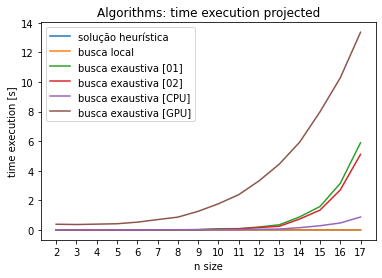

In [3]:
input_cut = 16
#results = run_multiple_times(exe_list, input_list[0:input_cut])
#save_results(results, path="./results/hle.pkl")
results = load_results("./results/hle.pkl")
print_lines(results, n_size_list[0:input_cut], "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

Tendo em vista que não é possível gerar os gráficos para valores muito grandes de N, foram feitas regressões para simular o comportamento dos algoritmos para valores maiores no eixo x. O resultado é apresentado abaixo.

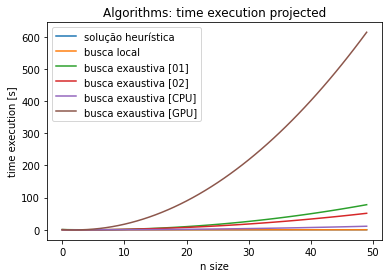

In [4]:
project_cut = 50
projected_results = project_results(results, 0, project_cut)
print_lines(projected_results, range(0, project_cut), "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 1)

Com base nos resultados obtidos, podemos tirar algumas conslusões macro dos algortimos apresentados. Em primeiro lugar, é possível notar que os algoritmos de busca local e solução heurística são os que levam menos tempo para retornar um resultado, já que não fazem todas as combinações possíveis como as abordagens de busca exaustiva. As duas abordagens serão analisadas separadamente, devido aos problemas de visualização causados pela escala do gráfico.

Em relação as abordagens de busca exaustiva sem paralelismo, pode-se dizer que existe uma diferença clara entre ambas. O uso do cálculo de score simples para sequências de mesmo tamanho pode não fazer tanta diferença quando temos valores pequenos de N, porém ao projetar os valores utilizando-se de regressões, podemos observar um claro ganho de desempenho entre os dois algoritmos, o que pode se justificar pelo alto custo computancional de preencher as matrizes n x m do Smith-Walterman.

Apesar de que as abordagens que utilizam paralelismo serão abordadas mais para frente de forma separada, pode-se observar que a abordagem utilizando CPUs para computar simultaneamente as subsequências geradas resulta em um grande ganho de desempenho, apesar de que veremos mais a frente que o problema continua tendo um comportamento exponencial, de forma que para valores muito grandes de N, ainda demandaria bastante tempo para se encontrar o resultado. Em contra partida, a implementação utilizando GPU aprensentou o pior desempenho dentre todos os algoritmos, o que será abordado na sessão de pontos de lentidão.

#### BUSCA LOCAL E SOLUÇÃO HEURÍSTICA (PARTE 2)

Como observado anteriormente, os algoritmos que executam com menor tempo são o de busca local e heurístico. Portanto vamos analisá-los novamente, porém dessa vez separados para que seja possível monitorar o seu comportamento para valores maiores de N. Os resultados estão apresentados logo abaixo.

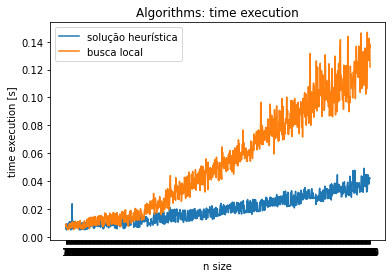

In [5]:
input_cut = 100000
#results_local_and_heuristic = run_multiple_times(['exe1', 'exe2'], input_list[0:input_cut])
#save_results(results_local_and_heuristic, path="./results/hl.pkl")
results_local_and_heuristic = load_results("./results/hl.pkl")
print_lines(results_local_and_heuristic, n_size_list[0:input_cut], "Algorithms: time execution", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 2)

Tomando como base o gráfico gerado acima, podemos observar que a solução heurística apresenta resultados muito próximos quando comparado à busca local para valores pequenos de n, entretanto, ao estrapolar o tamanho das sequências observamos uma diferença entre as duas abordagens. Isso pode ser explicado pelo fato de que o número de subsequências, p, geradas pelo algoritmo de busca local é proporcional ao tamanho N da entrada. Em outras palavras, quanto maior a entrada, mais subsequências serão geradas, dessa forma ocasionando em um maior tempo de execução.

Pode-se observar que o rúido (oscilação) do algoritmo de busca local aumenta conforme o tamanho da entrada: maior entrada, maior oscilação. Isso ocorre pois o valor de p (número de subsequências) é gerado de forma randômica dentro de um certo range de valores, de forma que P∈S|S = [n, 2n], onde n é o tamanho da entrada. Portanto quanto maior o tamanho da entrada, mais valores possíveis p pode assumir, causando o comportamento observado acima.

Vale notar que, apesar da solução heurística retornar o máximo global dos alinhamentos, o algoritmo pode ficar limitado quando os valores de N forem muito grandes. Isso ocorre pois, estrapolando os valores, a matriz necessária para calcular o Smith-Waterman seria enorme, resultando em problemas de alocação de memória.

#### BUSCA EXAUSTIVA SEM PARALELISMO (PARTE 3)

Nessa breve sessão vamos analisar de forma mais detalhada as abordagens que utilizam busca exaustiva sem paralelismo. Abaixo vemos os resultados encontrados.

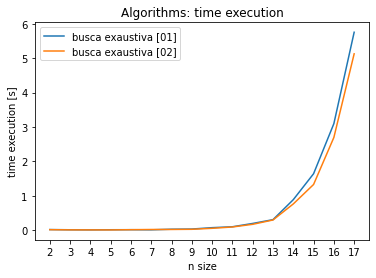

In [6]:
input_cut = 16
#results_ee = run_multiple_times(exe_list[2:4], input_list[0:input_cut])
#save_results(results_ee, path="./results/ee.pkl")
results_ee = load_results("./results/ee.pkl")
print_lines(results_ee, n_size_list[0:input_cut], "Algorithms: time execution", "n size", "time execution [s]", "clock")

Para umas melhor visualização do impacto causado nas diferentes abordagens, projetou-se os resultados utilizando regressões, como demonstrado abaixo.

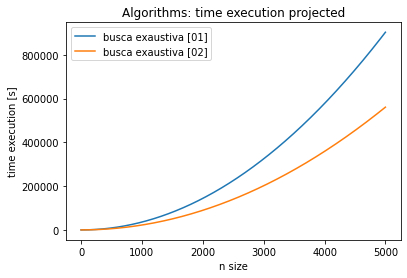

In [7]:
project_cut = 5000
projected_results = project_results(results_ee, 0, project_cut)
print_lines(projected_results, range(0, project_cut), "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 3)

Observa-se um crescente ganho de desempenho quando as duas implementações são comparadas. Como já dito anteriormente, a diferença no tempo de execução se dá pelo fato de que o segundo algoritmo (mais rápido), não utiliza o Smith-Walterman quando as duas subsequências de entrada são do mesmo tamanho, evitando alocar memória desnecessária.

In [8]:
exe3 = results_ee['exe3']['clock'][-1]
exe4 = results_ee['exe4']['clock'][-1]
print("Difenreça no tempo de execução para N = 16: {0} seg | {1}%".format(round(exe3-exe4, 0), round((exe3-exe4)*100/exe3, 2)))
exe3 = projected_results['exe3']['clock'][-1]
exe4 = projected_results['exe4']['clock'][-1]
print("Difenreça no tempo de execução para N = 5000: {0} seg | {1}%".format(round(exe3-exe4, 0), round((exe3-exe4)*100/exe3, 2)))

Difenreça no tempo de execução para N = 16: 1.0 seg | 10.91%
Difenreça no tempo de execução para N = 5000: 342097.0 seg | 37.9%


#### BUSCA EXAUSTIVA: COMPARATIVO GERAL (PARTE 4)

Nessa última etapa, será realizado uma análise geral de todos os algoritmos que implementam busca exaustiva. Essa análise tem como objetivo comparar as diferenças no tempo de execução causadas pelo uso de dois tipos diferentes de paralelismo, sendo eles: paralelismo usando CPU e paralelismo usando GPU. Abaixo temos um primeiro gráfico com resultados macro. 

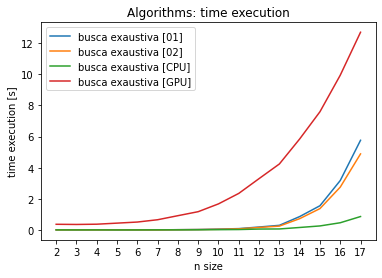

In [9]:
input_cut = 16
#results_eee = run_multiple_times(exe_list[2:7], input_list[0:input_cut])
#save_results(results_eee, path="./results/eee.pkl")
results_eee = load_results("./results/eee.pkl")
print_lines(results_eee, n_size_list[0:input_cut], "Algorithms: time execution", "n size", "time execution [s]", "clock")

Utilizando regressões para simular valores maiores de N, temos o resultado abaixo.

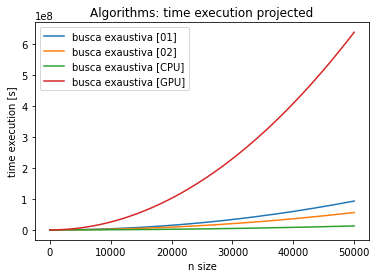

In [10]:
project_cut = 50000
projected_results = project_results(results_eee, 0, project_cut)
print_lines(projected_results, range(0, project_cut), "Algorithms: time execution projected", "n size", "time execution [s]", "clock")

#### CONCLUSÃO (PARTE 4)

Ao comparar o tempo de execução de ambas os algoritmos de busca exaustiva com a abordagem paralelizada com CPU, pode-se observar um ganho de desemepenho signficativo. Abaixo vemos uma análise quantitativa.

In [11]:
exe4 = results_ee['exe4']['clock'][-1]
exe5 = results_eee['exe5']['clock'][-1]
print("Difenreça no tempo de execução para N = 16: {0} seg | {1}%".format(round(exe4-exe5, 0), round((exe4-exe5)*100/exe4, 2)))
exe4 = projected_results['exe4']['clock'][-1]
exe5 = projected_results['exe5']['clock'][-1]
print("Difenreça no tempo de execução para N = 5000: {0} seg | {1}%".format(round(exe4-exe5, 0), round((exe4-exe5)*100/exe4, 2)))

Difenreça no tempo de execução para N = 16: 4.0 seg | 83.12%
Difenreça no tempo de execução para N = 5000: 43484302.0 seg | 77.25%


Porém ao realizar o mesmo cálculo comparando a implementação paralelizada com GPU temos uma piora significativa no tempo de execução.

In [16]:
exe5 = results_eee['exe5']['clock'][-1]
exe6 = results_eee['exe6']['clock'][-1]
print("Difenreça no tempo de execução para N = 16: {0} seg | {1}%".format(round(exe5-exe6, 0), round((exe5-exe6)*100/exe5, 2)))
exe5 = projected_results['exe5']['clock'][-1]
exe6 = projected_results['exe6']['clock'][-1]
print("Difenreça no tempo de execução para N = 5000: {0} seg | {1}%".format(round(exe5-exe6, 0), round((exe5-exe6)*100/exe5, 2)))

Difenreça no tempo de execução para N = 16: -12.0 seg | -1368.65%
Difenreça no tempo de execução para N = 5000: -625792539.0 seg | -4885.39%


#### SCORE OBTIDO: COMPARATIVO GERAL

Finalmente, vamos analisar o resultado obtido por cada um dos algoritmos implementado. Vale lembrar que não pe necessário, para essa análise, colocar todos os algoritmos de busca exaustiva, uma vez que todos eles retornarão o mesmo score, o máximo global. O mesmo vale para a solução heurística. Portanto, utilizou-se apenas duas implementações, busca local, a qual não retorna, necessariamente, o máximo global, e a solução heurística, a qual trará o melhor score.

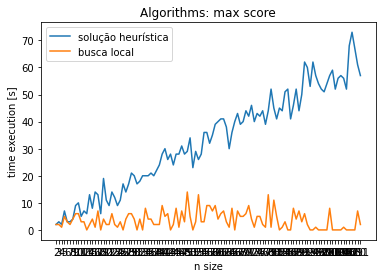

In [13]:
input_cut = 110
results_score = load_results("./results/score.pkl")
print_lines(results_score, n_size_list[0:input_cut], "Algorithms: max score", "n size", "time execution [s]", "result")

Analisando o gráfico acima, podemos ver que a busca local não é capaz de encontrar resultados tão bons quando os algoritmos que apresentam o máximo global. Uma forma de melhorar os resultados obtidos pela busca local é aumentar o número de subsequências geradas, de forma a vasculhar por mais possibilidades de alinhamento, e consequentemente melhorando os resultados encontrados.

### PONTOS DE LENTIDÃO

#### SOLUÇÃO HEURÍSITCA

Para a solução heurística foi indentificado um principal ponto de lentidão no código, a inicialização da matriz e o cálculo de seu conteúdo. Além da matriz ser de grande custo computacional, para valores muito grandes de N, torna-se inviável guardá-la na memória.

A imagem abaixo mostra um print do vallgrind, demonstrando o número de acesso à memória.

![HEUPROF](./images/heu-prof.png)

#### BUSCA LOCAL

Para a abordagem de busca local é possível afirmar que existem 2 principais pontos de lentidão. O primeiro deles é representado pela função "step3", na qual são geradas as p subsequências do algoritmo. Portanto, pode-se dizer que é importante notar que é perfeitamente possível fazer com que o modelo retorne o resultado mais rápido, basta diminuir o número de subsequências geradas.
O segundo ponto de lentidão condiz com a análise anteriormente feita na sessão de solução heurística, a inicialização e cálculo da matriz.

![HEUPROF](./images/loc-prof.png)

#### BUSCA EXAUSTIVA 

Para analisar as abordagens de busca exaustiva é necessário analisar por partes.

Primeiramente, como o cálculo do score para as três implementações, com excessão da abordagem com paralelismo em GPU, é igual, observamos novamente que a inicialização da matriz é um ponto de lentidão, bem como o cálculo de seu conteúdo.

![HEUPROF](./images/exa-prof.png)

Além disso, como na busca exaustiva é necessário computar diversas vezes o Smith-Walterman, a função "compare_letters" é requisitada diversas vezes, a qual é responsável por retornar, para uma dada célula da matriz, se será feita uma inserção, deleção ou alinhamento. Isso demanda que o algoritmo faça acessos em posições específicas da matriz, causando lentidão.

![HEUPROF](./images/exa-prof01.png)

Por fim, outro ponto de lentidão na busca exaustiva é gerar as subsequências para as entradas. Quanto maior a entrada, maior o tempo necessário para gerar todas as subsequências necessárias.

#### BUSCA EXUASTIVA GPU